# Competing Methods

In this Jupyter Notebook, we aim to focus on benchmarking competing methods for denoising and/or clustering and/or batch correcting of scRNA-seq data. The main methods we aim to compare with are scVI and MNN. DCA and scdeepcluster throw assertion errors as some of the data are not read counts. scVI can be used both to cluster and denoise rna-seq data. MNN can be used only to correct for batch effect as a preprocessing step to clustering (and other downstream analyses). Meanwhile, scVI is designed to batch correct data while clustering and denoising it as well.

Before running this notebook, please run the Rscripts "MNN_Pancreas.R" and "MNN_Pancreas_HVG.R"

## Setup

First, let's import requisite packages.

In [1]:
"""Broadly useful python packages"""
import pandas as pd
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
from time import time
from copy import deepcopy

"""Machine learning and single cell packages"""
import sklearn.metrics as metrics
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import scanpy as sc
from anndata import AnnData, concat
from keras.optimizers import Adam
from keras.models import Model
import torch
import scanorama

"""import CarDEC normalize function"""
from normalize_cardec import normalize_scanpy

"""import scVI Package"""
import scvi
from scvi.model import SCVI

Using TensorFlow backend.


Next, let's define some helper functions.

In [2]:
"""Miscellaneous useful functions"""

def read_pancreas(path, cache=True):
    """A function to read and preprocess the pancreas data"""
    pathlist = os.listdir(path)
    adata = sc.read(os.path.join(path, pathlist[0]))
    
    for i in range(1,len(pathlist)):
        adata = adata.concatenate(sc.read(os.path.join(path, pathlist[i])))

    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=30)
    mito_genes = adata.var_names.str.startswith('mt-')
    
    notmito_genes = [not x for x in mito_genes]
    adata = adata[:,notmito_genes]
    
    return(adata)

def read_pancreas_full(path,cache=True):
    adata = sc.read(path)
    
    return(adata)

def purity_score(y_true, y_pred):
    """A function to compute cluster purity"""
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)

    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

def convert_string_to_encoding(string, vector_key):
    """A function to convert a string to a numeric encoding"""
    return np.argwhere(vector_key == string)[0][0]

def convert_vector_to_encoding(vector, printkey = False):
    """A function to convert a vector of strings to a dense numeric encoding"""
    vector_key = np.unique(vector)
    if printkey:
        print(pd.Series(vector_key))
    
    vector_strings = list(vector)
    vector_num = [convert_string_to_encoding(string, vector_key) for string in vector_strings]
    
    return vector_num

def build_dir(dir_path):
    subdirs = [dir_path]
    substring = dir_path

    while substring != '':
        splt_dir = os.path.split(substring)
        substring = splt_dir[0]
        subdirs.append(substring)
        
    subdirs.pop()
    subdirs = [x for x in subdirs if os.path.basename(x) != '..']

    n = len(subdirs)
    subdirs = [subdirs[n - 1 - x] for x in range(n)]
    
    for dir_ in subdirs:
        if not os.path.isdir(dir_):
            os.mkdir(dir_)
            
def find_resolution(adata_, n_clusters, random = 0): 
    obtained_clusters = -1
    iteration = 0
    resolutions = [0., 1000.]
    
    while obtained_clusters != n_clusters and iteration < 50:
        current_res = sum(resolutions)/2
        adata = sc.tl.louvain(adata_, resolution = current_res, random_state = random, copy = True)
        labels = adata.obs['louvain']
        
        obtained_clusters = len(np.unique(labels))
        
        if obtained_clusters < n_clusters:
            resolutions[0] = current_res
        else:
            resolutions[1] = current_res
        
        iteration = iteration + 1
        
    return current_res

Lastly, let's grab the set of highly variable genes that were defined for CarDEC, so that we can use this same set for DCA clustering of denoised counts.

In [3]:
"""Read and normalize the data"""
adata = read_pancreas("../Data/pancreas", cache=True)

adata2 = normalize_scanpy(adata, batch_key = 'tech', n_high_var = 2000, LVG = True)

HVGs = adata2.var.index[adata2.var["Variance Type"] == "HVG"].values

Trying to set attribute `.var` of view, copying.
... storing 'tech' as categorical
/Users/jlakkis/anaconda3/envs/cardec_alternatives/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:848: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


## Figure Data

In [4]:
ARI_data = {'ARI': [0] * 2,
            'NMI': [0] * 2,
            'Purity': [0] * 2,
           'Method': ['Scanorama', 'scVI']}
ARI_data = pd.DataFrame(ARI_data)

ARI_data_gene = {'ARI': [0] * 6,
            'NMI': [0] * 6,
            'Purity': [0] * 6,
           'Method': ['Scanorama'] * 2 + ['scVI'] * 2 + ['MNN'] * 2,
                'Type': ['HVG', 'LVG'] * 3}
ARI_data_gene = pd.DataFrame(ARI_data_gene)

ARI_HVGo_gene = {'ARI': [0] * 3,
            'NMI': [0] * 3,
            'Purity': [0] * 3,
           'Method': ['Scanorama', 'scVI', 'MNN']}
ARI_HVGo_gene = pd.DataFrame(ARI_HVGo_gene)


figure_path = "../Figures/pancreas"
figure_path_supplement = "../Figures/pancreas_supplement"
figure_path_embedding = "../Figures/pancreas_embedding"

build_dir(figure_path)
build_dir(figure_path_supplement)
build_dir(figure_path_embedding)

## Scanorama

The first method to which we compare is Scanorama. Scanorama is a batch correction method that uses a nearest neighbors approach. For more information, please consult the references.

Manuscript: https://www.nature.com/articles/s41587-019-0113-3

Software: https://github.com/brianhie/scanorama

### HVGs Only

In [5]:
adata2 = adata.copy()
sc.pp.normalize_per_cell(adata2)
sc.pp.log1p(adata2)

Perform batch correction

In [6]:
# split per batch into new objects.
batches = adata2.obs['tech'].cat.categories.tolist()
alldata = {}
recover_id_list = []
for batch in batches:
    alldata[batch] = adata2[adata2.obs['tech'] == batch, HVGs].copy()
    recover_id_list.append(np.where(adata.obs["tech"] == batch)[0])
recover_id = np.concatenate(recover_id_list)

#convert to list of AnnData objects
adatas = list(alldata.values())

# run scanorama.integrate
corrected = scanorama.correct_scanpy(adatas, dimred = 50, return_dimred = True, verbose = False) #correct_scanpy,integrate_scanpy

Found 2000 genes among all datasets


In [7]:
# Get all the integrated matrices.
scanorama_int = [ad.obsm['X_scanorama'] for ad in corrected]
# make into one matrix.
all_s = np.concatenate(scanorama_int)
print(all_s.shape)

(6321, 50)


In [8]:
formatting = AnnData(all_s)
formatting.obs = adata[recover_id].obs.copy()

Get the predicted labels and compute adjusted rand score for the Scanorama embedding

Scanorama Clustering Results
ARI = 0.9397
NMI = 0.9141
Purity = 0.9616


... storing 'predicted' as categorical


Done


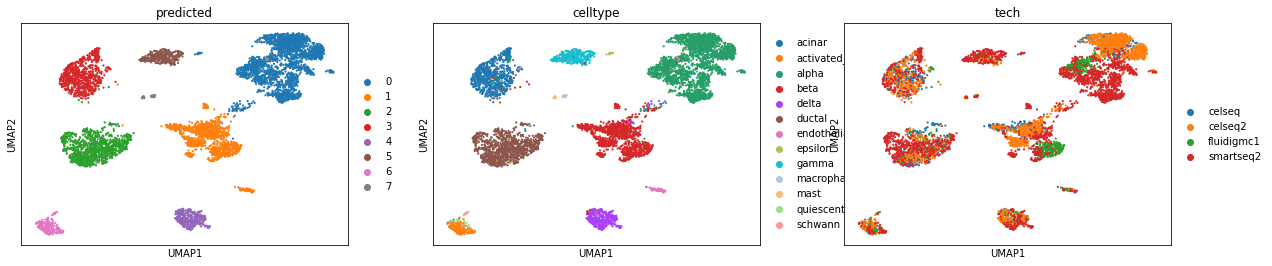

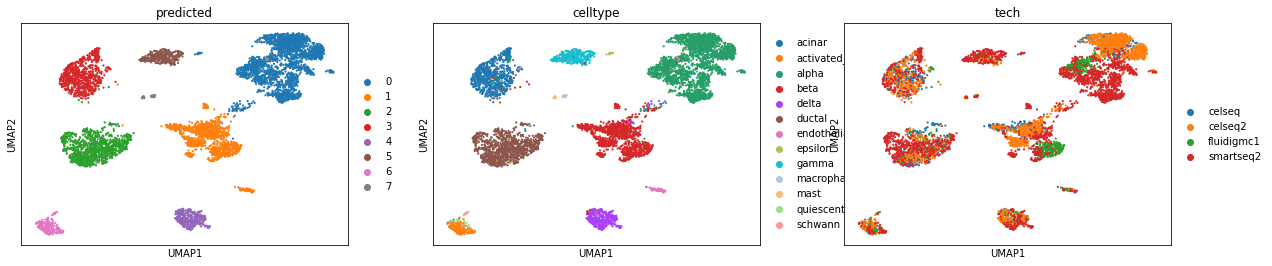

In [9]:
sc.pp.neighbors(formatting, n_neighbors = 15, use_rep = 'X')
res = find_resolution(formatting, 8)
formatting = sc.tl.louvain(formatting, resolution = res, copy = True)

labels = formatting.obs['louvain']
type_strings = list(formatting.obs['celltype'])

ARI, NMI, Purity = adjusted_rand_score(labels,type_strings), normalized_mutual_info_score(type_strings,labels), purity_score(type_strings,labels)

print("Scanorama Clustering Results")
print ("ARI = {0:.4f}".format(ARI)) 
print ("NMI = {0:.4f}".format(NMI)) 
print ("Purity = {0:.4f}".format(Purity))

formatting.obs["predicted"] = list(labels)
sc.tl.umap(formatting)
visual = sc.pl.umap(formatting, color = ["predicted", "celltype", "tech"], return_fig=True)
print("Done")

visual

In [10]:
adata_tmp = concat(corrected)

Get the predicted labels and compute adjusted rand score for the feature space (HVGs only)

... storing 'tech' as categorical


Scanorama Denoising Results for HVG
ARI = 0.9445
NMI = 0.9124
Purity = 0.9587


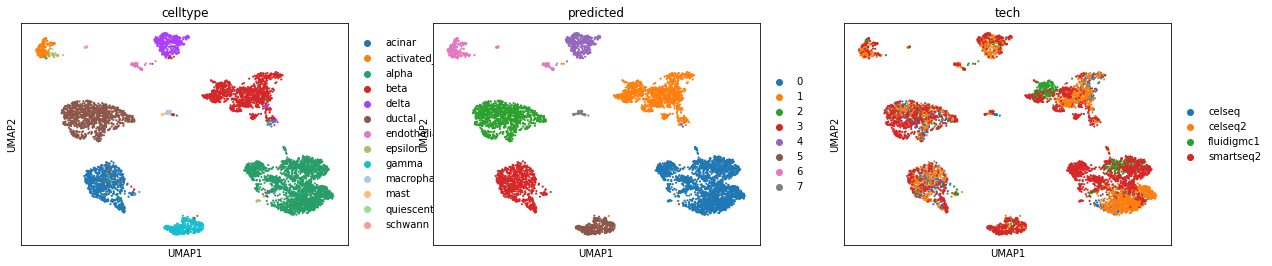

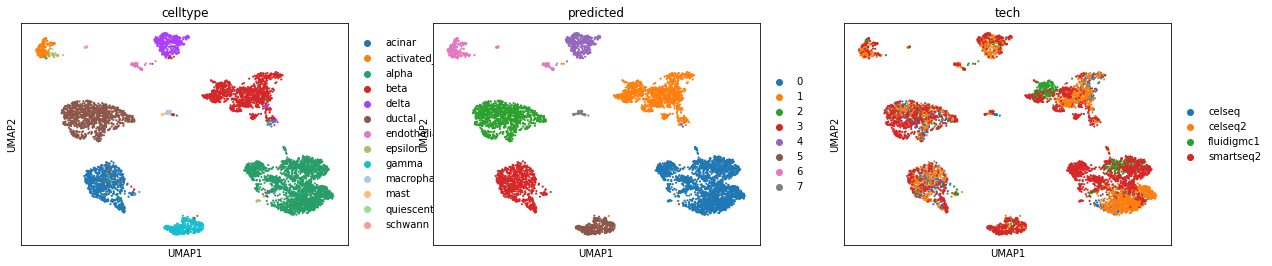

In [11]:
HVG_denoised = adata_tmp

sc.tl.pca(HVG_denoised, svd_solver='arpack')
sc.pp.neighbors(HVG_denoised, n_neighbors = 15)
sc.tl.umap(HVG_denoised)
res = find_resolution(HVG_denoised, 8)
HVG_denoised = sc.tl.louvain(HVG_denoised, resolution = res, copy = True)

labels = HVG_denoised.obs['louvain']
HVG_denoised.obs['predicted'] = HVG_denoised.obs['louvain']
type_strings = list(HVG_denoised.obs['celltype'])

print("Scanorama Denoising Results for HVG")

visual = sc.pl.umap(HVG_denoised, color = ["celltype", "predicted", "tech"], return_fig = True)
ARI, NMI, Purity = adjusted_rand_score(labels,type_strings), normalized_mutual_info_score(type_strings,labels), purity_score(type_strings,labels)

print ("ARI = {0:.4f}".format(ARI)) 
print ("NMI = {0:.4f}".format(NMI)) 
print ("Purity = {0:.4f}".format(Purity))

"""Figure info for paper"""
ARI_HVGo_gene.iloc[0,:3] = ARI, NMI, Purity
DF = pd.DataFrame(HVG_denoised.obsm['X_umap'])
DF.columns = ['UMAP1', 'UMAP2']
DF['Technology'] = HVG_denoised.obs['tech'].values
DF['Cell Type'] = HVG_denoised.obs['celltype'].values
DF.index = HVG_denoised.obs.index

base_path = 'Scanorama_HVGOnly.csv'
path = os.path.join(figure_path_supplement, base_path)

DF.to_csv(path)

visual

### All Genes

In [12]:
adata2 = adata.copy()
sc.pp.normalize_per_cell(adata2)
sc.pp.log1p(adata2)

Perform batch correction

In [13]:
# split per batch into new objects.
batches = adata2.obs['tech'].cat.categories.tolist()
alldata = {}
recover_id_list = []
for batch in batches:
    alldata[batch] = adata2[adata2.obs['tech'] == batch].copy()
    recover_id_list.append(np.where(adata.obs["tech"] == batch)[0])
recover_id = np.concatenate(recover_id_list)

#convert to list of AnnData objects
adatas = list(alldata.values())

# run scanorama.integrate
corrected = scanorama.correct_scanpy(adatas, dimred = 50, return_dimred = True, verbose = False) #correct_scanpy,integrate_scanpy

Found 21215 genes among all datasets


In [14]:
# Get all the integrated matrices.
scanorama_int = [ad.obsm['X_scanorama'] for ad in corrected]
# make into one matrix.
all_s = np.concatenate(scanorama_int)
print(all_s.shape)

(6321, 50)


In [15]:
formatting = AnnData(all_s)
formatting.obs = adata[recover_id].obs.copy()

Get the predicted labels and compute adjusted rand score for the Scanorama embedding

Scanorama Clustering Results
ARI = 0.4439
NMI = 0.6201
Purity = 0.6898


... storing 'predicted' as categorical


Done


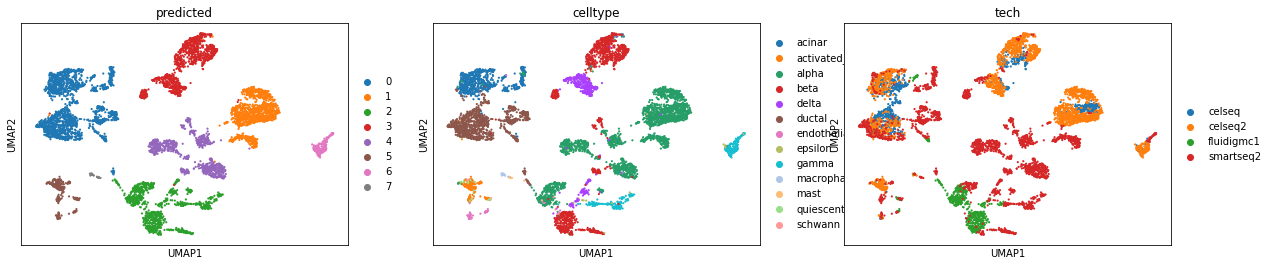

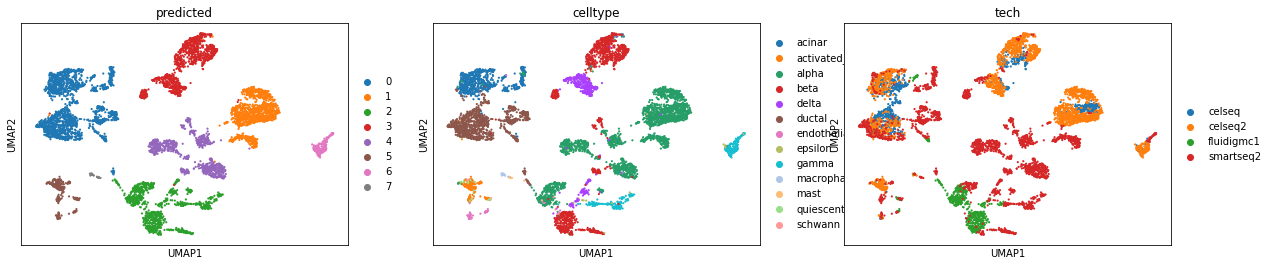

In [16]:
sc.pp.neighbors(formatting, n_neighbors = 15, use_rep = 'X')
res = find_resolution(formatting, 8)
formatting = sc.tl.louvain(formatting, resolution = res, copy = True)

labels = formatting.obs['louvain']
type_strings = list(formatting.obs['celltype'])

ARI, NMI, Purity = adjusted_rand_score(labels,type_strings), normalized_mutual_info_score(type_strings,labels), purity_score(type_strings,labels)

print("Scanorama Clustering Results")
print ("ARI = {0:.4f}".format(ARI)) 
print ("NMI = {0:.4f}".format(NMI)) 
print ("Purity = {0:.4f}".format(Purity))

formatting.obs["predicted"] = list(labels)
sc.tl.umap(formatting)
visual = sc.pl.umap(formatting, color = ["predicted", "celltype", "tech"], return_fig=True)
print("Done")

"""Figure info for paper"""
DF = pd.DataFrame(formatting.obsm['X_umap'])
DF.columns = ['UMAP1', 'UMAP2']
DF['Technology'] = HVG_denoised.obs['tech'].values
DF['Cell Type'] = HVG_denoised.obs['celltype'].values
DF.index = formatting.obs.index

base_path = 'Scanorama.csv'
path = os.path.join(figure_path_embedding, base_path)

DF.to_csv(path)

"""Figure info for paper"""

ARI_data.iloc[0,:3] = ARI, NMI, Purity

visual

In [17]:
adata_tmp = concat(corrected)

Get the predicted labels and compute adjusted rand score for the feature space (HVGs only)

... storing 'tech' as categorical


Scanorama Denoising Results for HVG
ARI = 0.7270
NMI = 0.8342
Purity = 0.9503


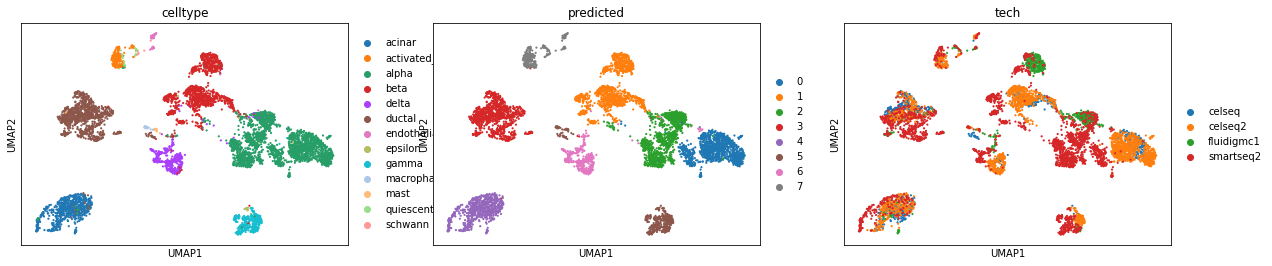

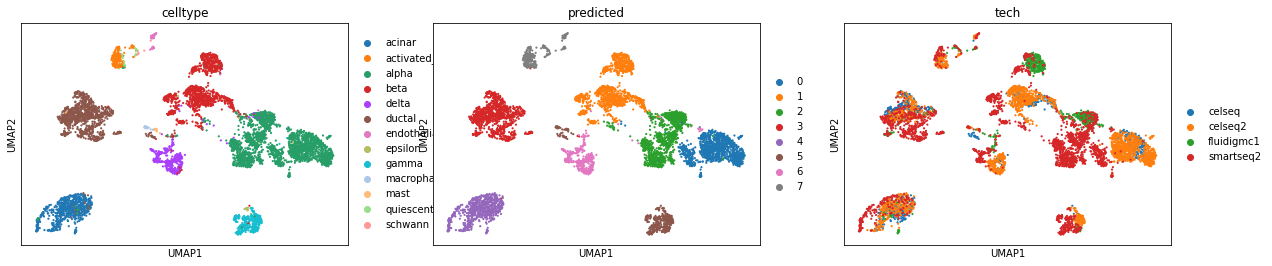

In [18]:
HVG_denoised = adata_tmp.copy()
indices = [x in HVGs for x in list(HVG_denoised.var.index)]
HVG_denoised = HVG_denoised[:, indices]

sc.tl.pca(HVG_denoised, svd_solver='arpack')
sc.pp.neighbors(HVG_denoised, n_neighbors = 15)
sc.tl.umap(HVG_denoised)
res = find_resolution(HVG_denoised, 8)
HVG_denoised = sc.tl.louvain(HVG_denoised, resolution = res, copy = True)

labels = HVG_denoised.obs['louvain']
HVG_denoised.obs['predicted'] = HVG_denoised.obs['louvain']
type_strings = list(HVG_denoised.obs['celltype'])

print("Scanorama Denoising Results for HVG")

visual = sc.pl.umap(HVG_denoised, color = ["celltype", "predicted", "tech"], return_fig = True)
ARI, NMI, Purity = adjusted_rand_score(labels,type_strings), normalized_mutual_info_score(type_strings,labels), purity_score(type_strings,labels)

print ("ARI = {0:.4f}".format(ARI)) 
print ("NMI = {0:.4f}".format(NMI)) 
print ("Purity = {0:.4f}".format(Purity))

"""Figure info for paper"""
ARI_data_gene.iloc[0,:3] = ARI, NMI, Purity
DF = pd.DataFrame(HVG_denoised.obsm['X_umap'])
DF.columns = ['UMAP1', 'UMAP2']
DF['Technology'] = HVG_denoised.obs['tech'].values
DF['Cell Type'] = HVG_denoised.obs['celltype'].values
DF.index = HVG_denoised.obs.index

base_path = 'Scanorama_HVG.csv'
path = os.path.join(figure_path, base_path)

DF.to_csv(path)

visual

Get the predicted labels and compute adjusted rand score for the feature space (LVGs only)

... storing 'tech' as categorical


Scanorama Denoising Results for LVG
ARI = 0.4086
NMI = 0.5778
Purity = 0.6966


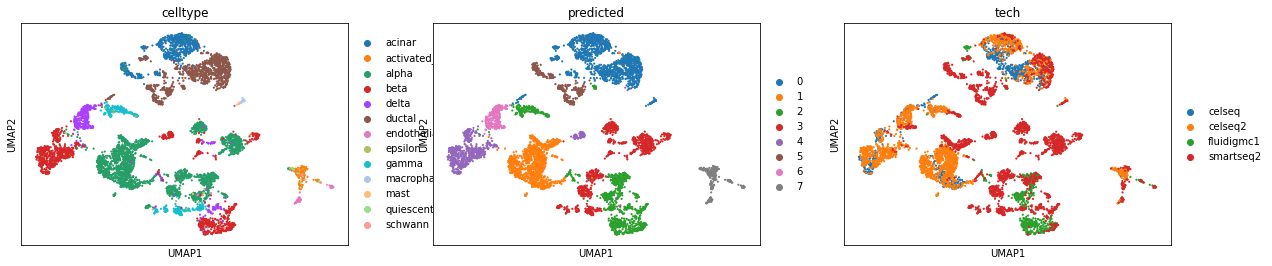

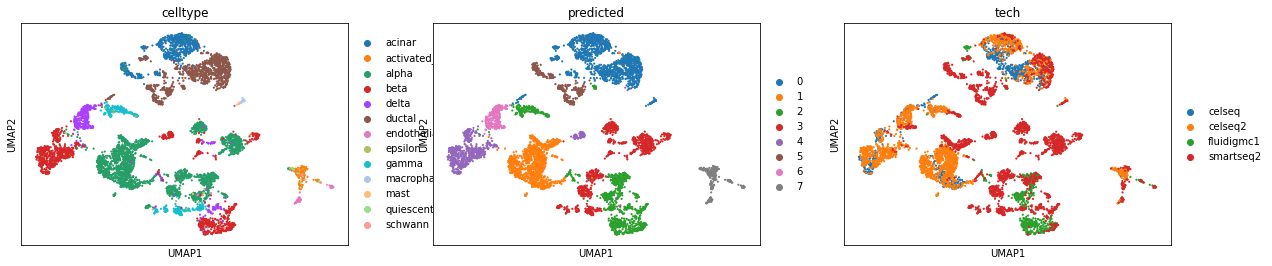

In [19]:
LVG_denoised = adata_tmp.copy()
indices = [x not in HVGs for x in list(LVG_denoised.var.index)]
LVG_denoised = LVG_denoised[:, indices]

sc.tl.pca(LVG_denoised, svd_solver='arpack')
sc.pp.neighbors(LVG_denoised, n_neighbors = 15)
sc.tl.umap(LVG_denoised)
res = find_resolution(LVG_denoised, 8)
LVG_denoised = sc.tl.louvain(LVG_denoised, resolution = res, copy = True)

labels = LVG_denoised.obs['louvain']
LVG_denoised.obs['predicted'] = LVG_denoised.obs['louvain']
type_strings = list(LVG_denoised.obs['celltype'])

print("Scanorama Denoising Results for LVG")

visual = sc.pl.umap(LVG_denoised, color = ["celltype", "predicted", "tech"], return_fig = True)
ARI, NMI, Purity = adjusted_rand_score(labels,type_strings), normalized_mutual_info_score(type_strings,labels), purity_score(type_strings,labels)

print ("ARI = {0:.4f}".format(ARI)) 
print ("NMI = {0:.4f}".format(NMI)) 
print ("Purity = {0:.4f}".format(Purity))

"""Figure info for paper"""
ARI_data_gene.iloc[1,:3] = ARI, NMI, Purity
DF = pd.DataFrame(LVG_denoised.obsm['X_umap'])
DF.columns = ['UMAP1', 'UMAP2']
DF['Technology'] = LVG_denoised.obs['tech'].values
DF['Cell Type'] = LVG_denoised.obs['celltype'].values
DF.index = LVG_denoised.obs.index

base_path = 'Scanorama_LVG.csv'
path = os.path.join(figure_path, base_path)

DF.to_csv(path)

visual

## scVI

In the second evaluation, we evalue scVI, single-cell Variational Inference. scVI is a variational inference model for denoising and downstream analysis of scRNA-seq data. Like DCA, it maximizes a zero inflated negative binomial likelihood. Unlike DCA, which uses a standard autoencoder, scVI fits a variational autoencoder. scVI is also designed to adjust for batch effects through the inclusion of indicators in the latent space. For more information, please consult the references.

Manuscript: https://www.nature.com/articles/s41592-018-0229-2

Software: https://github.com/YosefLab/scVI

First, let's create directories to save our models.

In [20]:
build_dir("scVI Results HVG/Pancreas")
build_dir("scVI Results HVGScanpy/Pancreas")
build_dir("scVI Results All/Pancreas")
build_dir("data")

use_cuda = False

anndataset = read_pancreas("../Data/pancreas", cache=True)
batch_vec = list(anndataset.obs['tech'])
arr = pd.DataFrame(anndataset.X.toarray(), index = anndataset.obs.index, columns = anndataset.var.index)
meta_data = pd.concat([pd.Series(anndataset.obs.index, index = anndataset.obs.index), anndataset.obs['tech']], axis = 1)

arr.to_csv(os.path.join('data', "scviPancreasdata.csv"), index = True)
meta_data.to_csv(os.path.join('data', "scviPancreasmetadata.csv"), index = False)
mypath = 'scviPancreasdata.csv'
mybatchpath = 'scviPancreasmetadata.csv'

#### HVGs Only

In [21]:
mypath = 'scviPancreasdata.csv'
mybatchpath = 'scviPancreasmetadata.csv'
sub_data = anndataset[:,HVGs].copy()
scvi.data.setup_anndata(sub_data, batch_key="tech")

vae = SCVI(sub_data, n_layers = 2)

filename = 'scVI Results HVG/Pancreas/bestmodelnew'

if not os.path.exists(filename):
        vae.train(n_epochs = 200)
        vae.save(dir_path = 'scVI Results HVG/Pancreas/bestmodelnew')
        
vae = vae.load(sub_data, dir_path = filename)

latent = vae.get_latent_representation()
normalized_values = vae.get_normalized_expression(
    library_size=1e4, 
    transform_batch = "celseq", 
    n_samples=10, 
    return_mean=True,
)

INFO     Using batches from adata.obs["tech"]                                                
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 6321 cells, 2000 genes, 4 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          
WARNING  Make sure the registered X field in anndata contains unnormalized count data.       
WARNING  Make sure the registered X field in anndata contains unnormalized count data.       
WARNING  Make sure the registered X field in anndata contain

/Users/jlakkis/anaconda3/envs/cardec_alternatives/lib/python3.7/site-packages/scvi/data/_anndata.py:790: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  logger_data_loc


Now, we cluster cells using the denoised counts of the top 2000 highly variable genes using scanpy. We visualize the denoised counts using UMAP, and compute the various clustering accuracy metrics.

Trying to set attribute `.obs` of view, copying.
... storing 'tech' as categorical


scVI Denoising Results for HVG
ARI = 0.9302
NMI = 0.8998
Purity = 0.9141


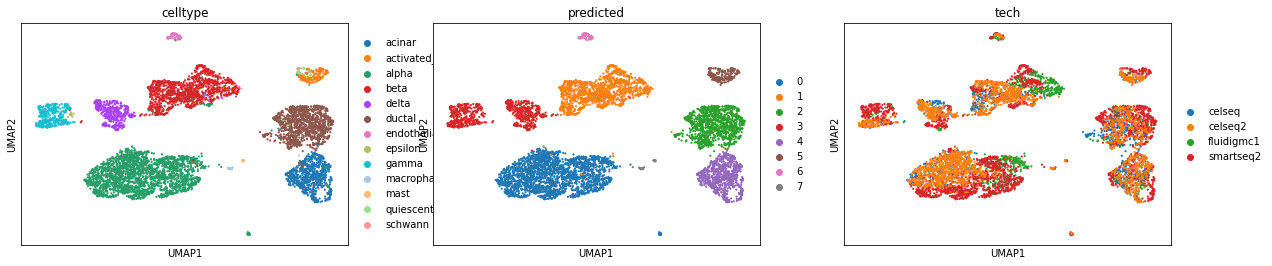

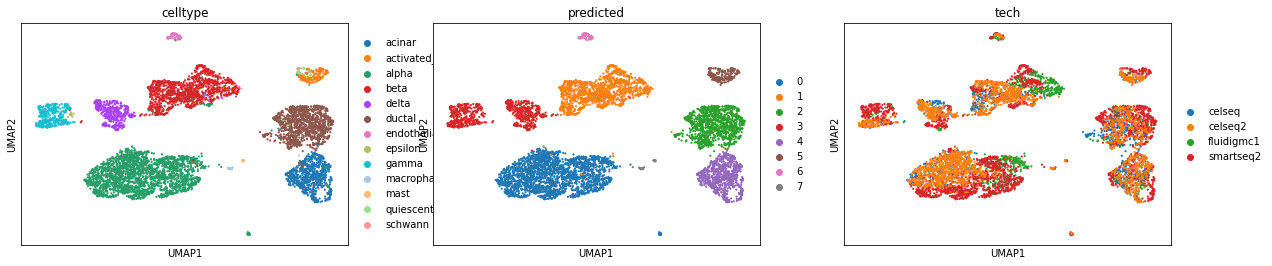

In [22]:
HVG_denoised = AnnData(deepcopy(normalized_values))
HVG_denoised.obs = anndataset.obs
HVG_denoised.obs['tech'] = batch_vec

sc.pp.log1p(HVG_denoised)
sc.pp.scale(HVG_denoised)

sc.tl.pca(HVG_denoised, svd_solver='arpack')
sc.pp.neighbors(HVG_denoised, n_neighbors = 15)
sc.tl.umap(HVG_denoised)
res = find_resolution(HVG_denoised, 8)
HVG_denoised = sc.tl.louvain(HVG_denoised, resolution = res, copy = True)

labels = HVG_denoised.obs['louvain']
HVG_denoised.obs['predicted'] = HVG_denoised.obs['louvain']
type_strings = list(HVG_denoised.obs['celltype'])

print("scVI Denoising Results for HVG")

visual = sc.pl.umap(HVG_denoised, color = ["celltype", "predicted", "tech"], return_fig=True)
ARI, NMI, Purity = adjusted_rand_score(labels,type_strings), normalized_mutual_info_score(type_strings,labels), purity_score(type_strings,labels)

print ("ARI = {0:.4f}".format(ARI)) 
print ("NMI = {0:.4f}".format(NMI)) 
print ("Purity = {0:.4f}".format(Purity))

"""Figure info for main paper"""
ARI_HVGo_gene.iloc[1,:3] = ARI, NMI, Purity
DF = pd.DataFrame(HVG_denoised.obsm['X_umap'])
DF.columns = ['UMAP1', 'UMAP2']
DF['Technology'] = HVG_denoised.obs['tech'].values
DF['Cell Type'] = HVG_denoised.obs['celltype'].values
DF.index = HVG_denoised.obs.index

base_path = 'scVI_HVGOnly.csv'
path = os.path.join(figure_path_supplement, base_path)

DF.to_csv(path)

visual

Then, we cluster cells using the low-dimensional latent space learned by scVI using scanpy. We visualize the latent space using UMAP, and compute the various clustering accuracy metrics.

scVI Clustering Results
ARI = 0.9524
NMI = 0.9247
Purity = 0.9679


... storing 'celltype' as categorical
... storing 'predicted' as categorical
... storing 'tech' as categorical


Done


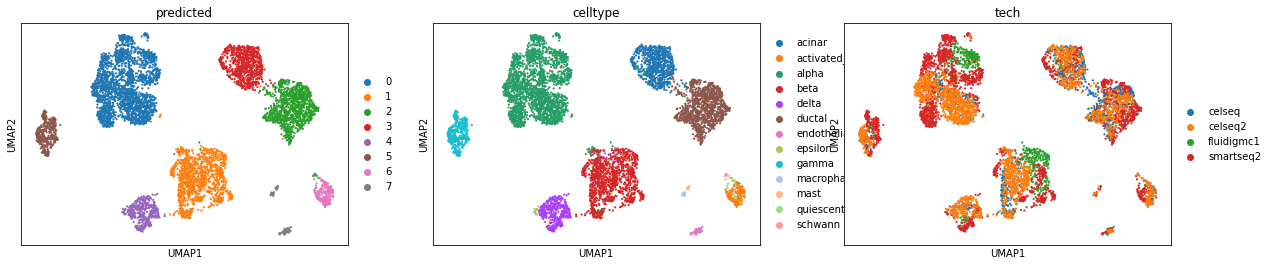

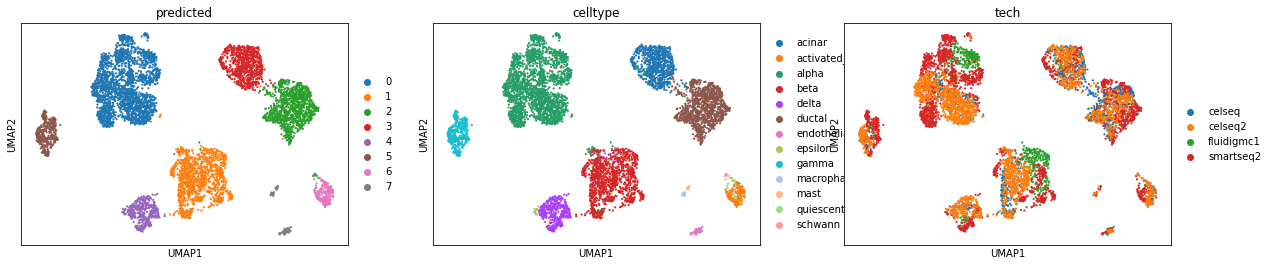

In [23]:
"""Get the predicted labels and compute adjusted rand score for the scVI embedding"""

emb = deepcopy(latent)

formatting = AnnData(emb)
sc.pp.neighbors(formatting, n_neighbors = 30, use_rep = 'X')
res = find_resolution(formatting, 8) #cannot detect more than 12 cell types reliably
formatting = sc.tl.louvain(formatting, resolution = res, copy = True)

labels = formatting.obs['louvain']
type_strings = list(anndataset.obs['celltype'])

ARI, NMI, Purity = adjusted_rand_score(labels,type_strings), normalized_mutual_info_score(type_strings,labels), purity_score(type_strings,labels)

print("scVI Clustering Results")
print ("ARI = {0:.4f}".format(ARI)) 
print ("NMI = {0:.4f}".format(NMI)) 
print ("Purity = {0:.4f}".format(Purity))

formatting.obs["celltype"] = list(anndataset.obs['celltype'])
formatting.obs["predicted"] = list(labels)
formatting.obs["tech"] = batch_vec
formatting.obs['tech'] = [str(x) for x in formatting.obs['tech']]

sc.tl.umap(formatting)
visual = sc.pl.umap(formatting, color = ["predicted", "celltype", "tech"], return_fig=True)
print("Done")

visual

#### All Genes

Now, we evaluate an scVI model that was fit using all genes.

In [24]:
scvi.data.setup_anndata(anndataset, batch_key="tech")

vae = SCVI(anndataset, n_layers = 2)

filename = 'scVI Results All/Pancreas/bestmodelnew'

if not os.path.exists(filename):
    vae.train(n_epochs = 200)
    vae.save(dir_path = 'scVI Results All/Pancreas/bestmodelnew')
        
vae = vae.load(anndataset, dir_path = 'scVI Results All/Pancreas/bestmodelnew')

latent = vae.get_latent_representation()
normalized_values = vae.get_normalized_expression(
    library_size=1e4, 
    transform_batch = "celseq", 
    n_samples=10, 
    return_mean=True,
)

INFO     Using batches from adata.obs["tech"]                                                
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              


/Users/jlakkis/anaconda3/envs/cardec_alternatives/lib/python3.7/site-packages/scvi/data/_anndata.py:790: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  logger_data_loc


INFO     Successfully registered anndata object containing 6321 cells, 21215 genes, 4        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          
WARNING  Make sure the registered X field in anndata contains unnormalized count data.       
WARNING  Make sure the registered X field in anndata contains unnormalized count data.       
WARNING  Make sure the registered X field in anndata contains unnormalized count data.       
WARNING  Make sure the registered X field in anndata contains unnormalized count data.       
WARNING  Make sure the registered X field in anndata contains unnormalized count data.       


Now, we cluster cells using the denoised counts of all genes using scanpy. We visualize the denoised counts using UMAP, and compute the various clustering accuracy metrics.

... storing 'tech' as categorical


scVI Denoising Results for All Genes
ARI = 0.3311
NMI = 0.4998
Purity = 0.6482


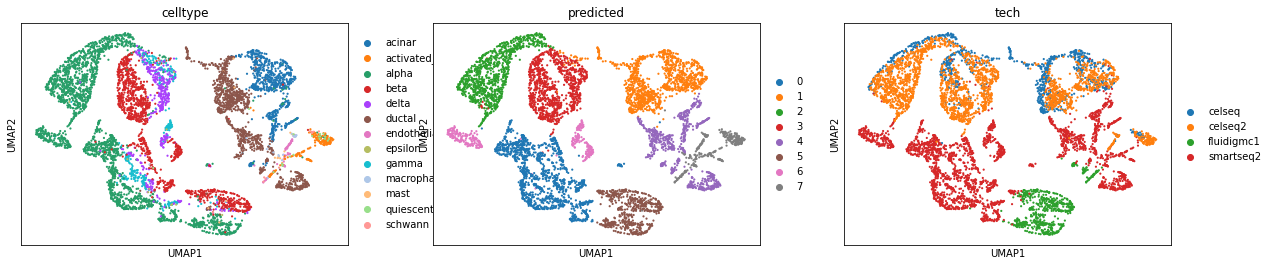

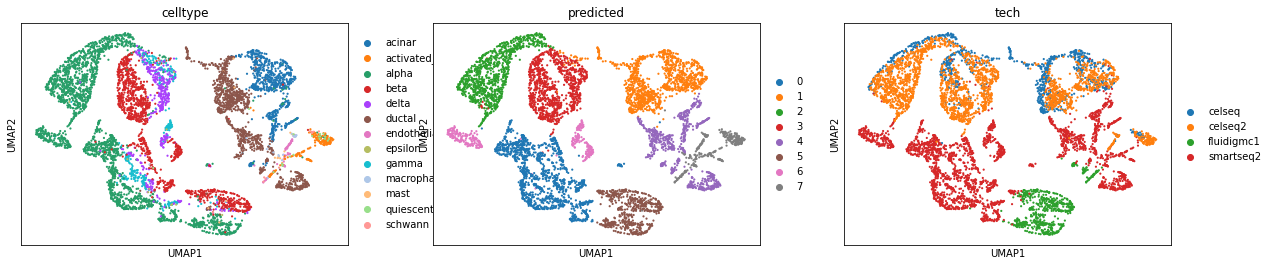

In [25]:
All_denoised = AnnData(deepcopy(normalized_values))
All_denoised.obs = anndataset.obs
All_denoised.obs['tech'] = batch_vec
All_denoised.write(filename="scVI Results All/Pancreas/denoised_scVI.h5ad")

sc.pp.log1p(All_denoised)
sc.pp.scale(All_denoised)

sc.tl.pca(All_denoised, svd_solver='arpack')
sc.pp.neighbors(All_denoised, n_neighbors = 15)
sc.tl.umap(All_denoised)
res = find_resolution(All_denoised, 8)
All_denoised = sc.tl.louvain(All_denoised, resolution = res, copy = True)

labels = All_denoised.obs['louvain']
All_denoised.obs['predicted'] = All_denoised.obs['louvain']
type_strings = list(All_denoised.obs['celltype'])

print("scVI Denoising Results for All Genes")

visual = sc.pl.umap(All_denoised, color = ["celltype", "predicted", "tech"], return_fig=True)
ARI, NMI, Purity = adjusted_rand_score(labels,type_strings), normalized_mutual_info_score(type_strings,labels), purity_score(type_strings,labels)

print ("ARI = {0:.4f}".format(ARI)) 
print ("NMI = {0:.4f}".format(NMI)) 
print ("Purity = {0:.4f}".format(Purity))

visual

/Users/jlakkis/anaconda3/envs/cardec_alternatives/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
... storing 'tech' as categorical


scVI Denoising Results for HVG Genes, from model trained with all genes
ARI = 0.4538
NMI = 0.6141
Purity = 0.7621


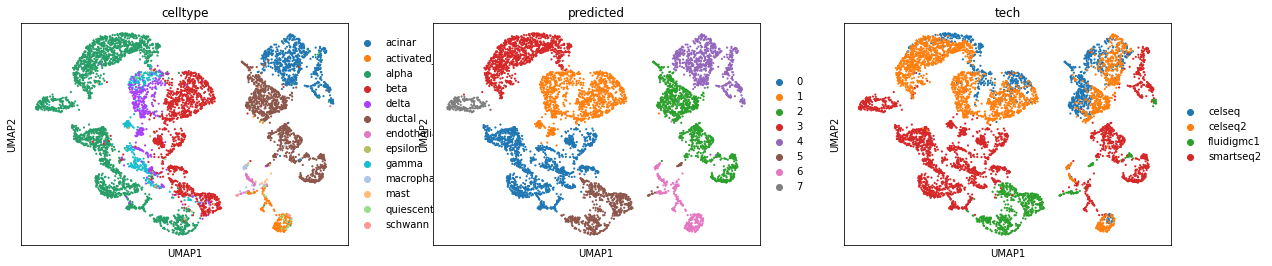

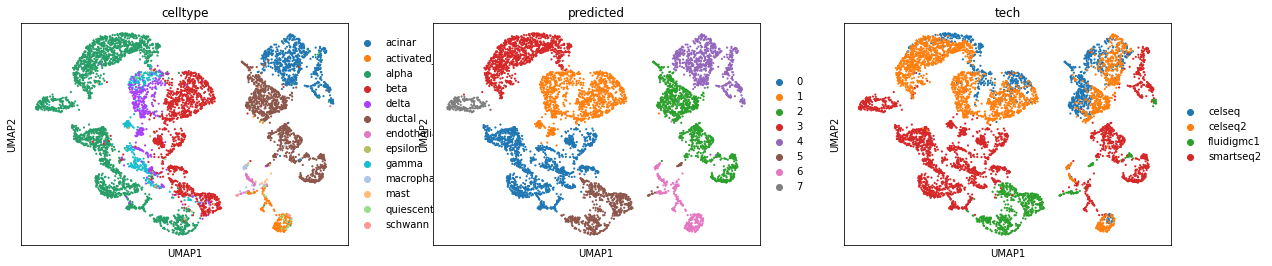

In [26]:
All_denoised = AnnData(deepcopy(normalized_values))
All_denoised.obs = anndataset.obs
All_denoised.obs['tech'] = list(batch_vec)
indices = [x in HVGs for x in list(anndataset.var.index)]
All_denoised = All_denoised[:, indices]

sc.pp.log1p(All_denoised)
sc.pp.scale(All_denoised)

sc.tl.pca(All_denoised, svd_solver='arpack')
sc.pp.neighbors(All_denoised, n_neighbors = 15)
sc.tl.umap(All_denoised)
res = find_resolution(All_denoised, 8)
All_denoised = sc.tl.louvain(All_denoised, resolution = res, copy = True)

labels = All_denoised.obs['louvain']
All_denoised.obs['predicted'] = All_denoised.obs['louvain']
type_strings = list(All_denoised.obs['celltype'])

print("scVI Denoising Results for HVG Genes, from model trained with all genes")

All_denoised.obs['tech'] = list(batch_vec)
visual = sc.pl.umap(All_denoised, color = ["celltype", "predicted", "tech"], return_fig=True)
ARI, NMI, Purity = adjusted_rand_score(labels,type_strings), normalized_mutual_info_score(type_strings,labels), purity_score(type_strings,labels)

print ("ARI = {0:.4f}".format(ARI)) 
print ("NMI = {0:.4f}".format(NMI)) 
print ("Purity = {0:.4f}".format(Purity))

"""Figure info for main paper"""
ARI_data_gene.iloc[2,:3] = ARI, NMI, Purity
DF = pd.DataFrame(All_denoised.obsm['X_umap'])
DF.columns = ['UMAP1', 'UMAP2']
DF['Technology'] = All_denoised.obs['tech'].values
DF['Cell Type'] = All_denoised.obs['celltype'].values
DF.index = All_denoised.obs.index

base_path = 'scVI_HVG.csv'
path = os.path.join(figure_path, base_path)

DF.to_csv(path)

visual

/Users/jlakkis/anaconda3/envs/cardec_alternatives/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
... storing 'tech' as categorical


scVI Denoising Results for LVG Genes, from model trained with all genes
ARI = 0.3171
NMI = 0.4660
Purity = 0.6368


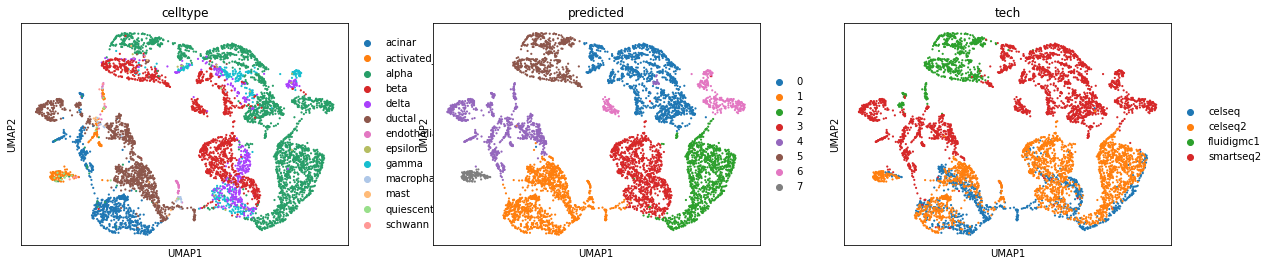

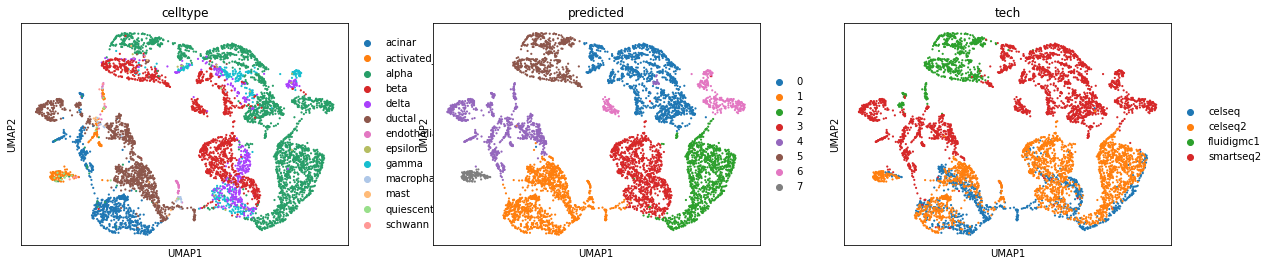

In [27]:
All_denoised = AnnData(deepcopy(normalized_values))
All_denoised.obs = anndataset.obs
All_denoised.obs['tech'] = batch_vec
indices = [x not in HVGs for x in list(anndataset.var.index)]
All_denoised = All_denoised[:, indices]

sc.pp.log1p(All_denoised)
sc.pp.scale(All_denoised)

sc.tl.pca(All_denoised, svd_solver='arpack')
sc.pp.neighbors(All_denoised, n_neighbors = 15)
sc.tl.umap(All_denoised)
res = find_resolution(All_denoised, 8)
All_denoised = sc.tl.louvain(All_denoised, resolution = res, copy = True)

labels = All_denoised.obs['louvain']
All_denoised.obs['predicted'] = All_denoised.obs['louvain']
type_strings = list(All_denoised.obs['celltype'])

print("scVI Denoising Results for LVG Genes, from model trained with all genes")


All_denoised.obs['tech'] = list(batch_vec)
visual = sc.pl.umap(All_denoised, color = ["celltype", "predicted", "tech"], return_fig=True)
ARI, NMI, Purity = adjusted_rand_score(labels,type_strings), normalized_mutual_info_score(type_strings,labels), purity_score(type_strings,labels)

print ("ARI = {0:.4f}".format(ARI)) 
print ("NMI = {0:.4f}".format(NMI)) 
print ("Purity = {0:.4f}".format(Purity))

"""Figure info for main paper"""
ARI_data_gene.iloc[3,:3] = ARI, NMI, Purity
DF = pd.DataFrame(All_denoised.obsm['X_umap'])
DF.columns = ['UMAP1', 'UMAP2']
DF['Technology'] = All_denoised.obs['tech'].values
DF['Cell Type'] = All_denoised.obs['celltype'].values
DF.index = All_denoised.obs.index

base_path = 'scVI_LVG.csv'
path = os.path.join(figure_path, base_path)

DF.to_csv(path)

visual

Then, we cluster cells using the low-dimensional latent space learned by scVI using scanpy. We visualize the latent space using UMAP, and compute the various clustering accuracy metrics.

scVI Clustering Results
ARI = 0.3216
NMI = 0.4748
Purity = 0.6366


... storing 'celltype' as categorical
... storing 'predicted' as categorical
... storing 'tech' as categorical


Done


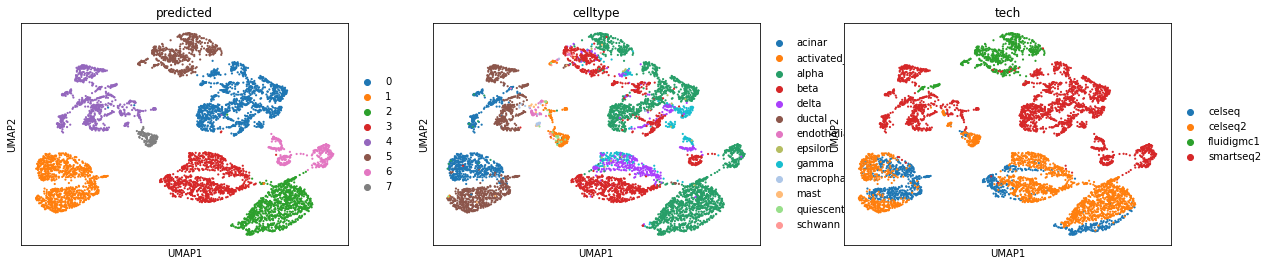

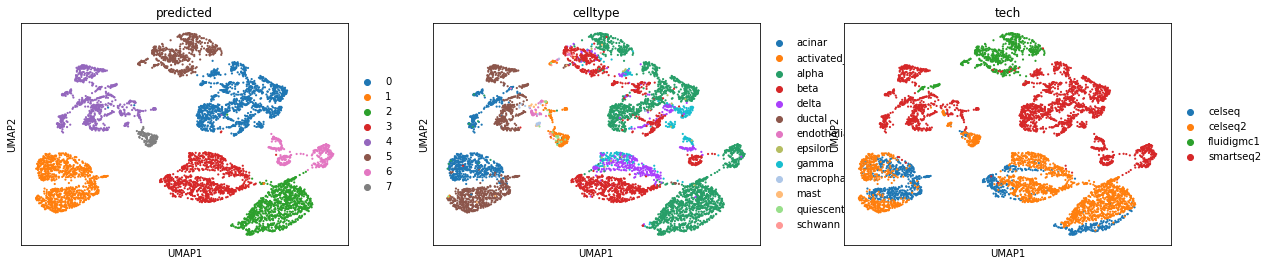

In [28]:
"""Get the predicted labels and compute adjusted rand score for the scVI embedding"""

emb = deepcopy(latent)

formatting = AnnData(emb)
sc.pp.neighbors(formatting, n_neighbors = 15, use_rep = 'X')
res = find_resolution(formatting, 8)
formatting = sc.tl.louvain(formatting, resolution = res, copy = True)

labels = formatting.obs['louvain']
type_strings = list(anndataset.obs['celltype'])

ARI, NMI, Purity = adjusted_rand_score(labels,type_strings), normalized_mutual_info_score(type_strings,labels), purity_score(type_strings,labels)

print("scVI Clustering Results")
print ("ARI = {0:.4f}".format(ARI)) 
print ("NMI = {0:.4f}".format(NMI)) 
print ("Purity = {0:.4f}".format(Purity))

formatting.obs["celltype"] = list(anndataset.obs['celltype'])
formatting.obs["predicted"] = list(labels)
formatting.obs["tech"] = batch_vec

sc.tl.umap(formatting)
visual = sc.pl.umap(formatting, color = ["predicted", "celltype", "tech"], return_fig=True)
print("Done")

"""Figure info for paper"""
DF = pd.DataFrame(formatting.obsm['X_umap'])
DF.columns = ['UMAP1', 'UMAP2']
DF['Technology'] = formatting.obs['tech'].values
DF['Cell Type'] = formatting.obs['celltype'].values
DF.index = formatting.obs.index

base_path = 'scVI.csv'
path = os.path.join(figure_path_embedding, base_path)

DF.to_csv(path)

ARI_data.iloc[1,:3] = ARI, NMI, Purity
ARI_data.to_csv(os.path.join(figure_path_embedding, 'ARIsummary_competitors.csv'))

visual

## MNN

Lastly, we run Mutual Nearest Neighbors (MNN). The premise of MNN is to find pairs of mutual nearest neighbor cells between batches. The theory behind MNN is that any differences between cells in these MNN pairs are good estimates of batch effects. Averaging these differences over many MNN pairs then provides a better estimate of batch effect, and a correction vector can be applied to correct the count matrix. With the corrected counts, we can then perform downstream analysis like clustering. For more information, please consult the references:

Manuscript: https://www.nature.com/articles/nbt.4091

Software: https://bioconductor.org/packages/release/bioc/html/batchelor.html

A few comments.
    1. MNN can be run in python using the mnnpy package. However, the installation of mnnpy fails to build on a MacOS system. As I work only on MacOS, I had to improvise and run mnnCorrect in R, save the corrected counts to the disk as "corrected_data.csv," and then load the matrix into this notebook to run downstream louvain clustering on it with scanpy. For this reason, MNN itself is not implemented in this notebook. Please see the Rscript for the implementation. Rscript for MNN with HVGs only is "MNN_Pancreas_HVG.R", and MNN with all genes is implemented in "MNN_Pancreas.R"
    2. Following the author's reccomendation, the count matrix is corrected for sequencing depth via size factors, and is then logtransformed before being fed into MNN. All of this is done in the R script. For a citation of the author's suggested normlization method, please see the link below.
    3. Following the author's reccomendation, the outputted corrected matrix from MNN is fed directly in scanpy's louvain clustering. No normalization of any kind is performed, as the author suggests that no normalization is needed after MNN correction. For citation of this, see the same link cited in comment 2.

Author's Comments: https://support.bioconductor.org/p/106010/

#### HVGs

In [29]:
MNNdata = pd.read_csv("MNNcorrected_hvg/corrected_data_Pancreas.csv", index_col = 0)
meta_data = pd.read_csv("MNNcorrected_hvg/corrected_metadata_Pancreas.csv", index_col = 0)
MNNdata = MNNdata.T

In [30]:
MNNdata_frame = AnnData(MNNdata)
MNNdata_frame.obs = meta_data
adata = read_pancreas("../Data/pancreas", cache=True)
MNNdata_frame.obs['tech'] = adata.obs['tech'].values

del MNNdata, meta_data, adata

MNNdata_frame

AnnData object with n_obs × n_vars = 6321 × 2000
    obs: 'celltype', 'tech', 'n_genes', 'percent_mito', 'n_counts'

First, we cluster cells using the batch corrected counts of highly variable genes using scanpy. We visualize the corrected counts using UMAP, and compute the various clustering accuracy metrics.

... storing 'celltype' as categorical
... storing 'tech' as categorical


MNN Batch Corrected Clustering Results for HVG
ARI = 0.7912
NMI = 0.8342
Purity = 0.8030


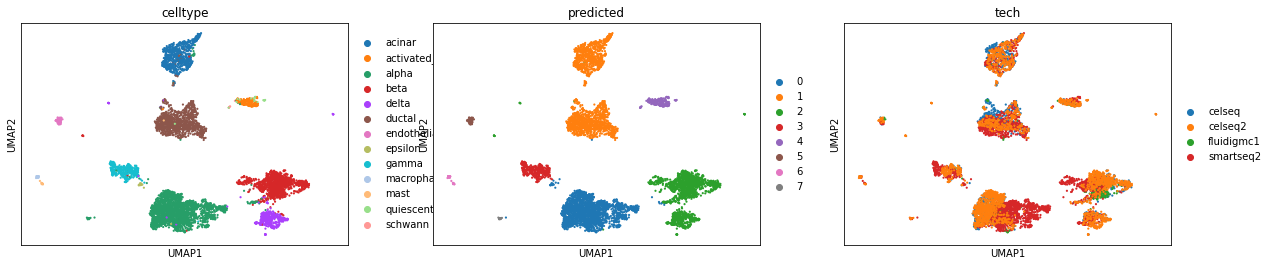

In [31]:
MNN_HVG = MNNdata_frame.copy()

sc.tl.pca(MNN_HVG, svd_solver='arpack')
sc.pp.neighbors(MNN_HVG, n_neighbors = 15)
sc.tl.umap(MNN_HVG)
res = find_resolution(MNN_HVG, 8)
MNN_HVG = sc.tl.louvain(MNN_HVG, resolution = res, copy = True)

labels = MNN_HVG.obs['louvain']
MNN_HVG.obs['predicted'] = MNN_HVG.obs['louvain']
type_strings = list(MNN_HVG.obs['celltype'])

print("MNN Batch Corrected Clustering Results for HVG")

visual = sc.pl.umap(MNN_HVG, color = ["celltype", "predicted", "tech"], return_fig=True)
ARI, NMI, Purity = adjusted_rand_score(labels,type_strings), normalized_mutual_info_score(type_strings,labels), purity_score(type_strings,labels)

print ("ARI = {0:.4f}".format(ARI)) 
print ("NMI = {0:.4f}".format(NMI)) 
print ("Purity = {0:.4f}".format(Purity))

visual

"""Figure info for main paper"""
ARI_HVGo_gene.iloc[2,:3] = ARI, NMI, Purity
DF = pd.DataFrame(MNN_HVG.obsm['X_umap'])
DF.columns = ['UMAP1', 'UMAP2']
DF['Technology'] = MNN_HVG.obs['tech'].values
DF['Cell Type'] = MNN_HVG.obs['celltype'].values
DF.index = MNN_HVG.obs.index

base_path = 'MNN_HVGOnly.csv'
path = os.path.join(figure_path_supplement, base_path)

DF.to_csv(path)

#### All Genes

First, we load the corrected matrix into python, along with metadata. Then, these loaded representations are converted to an Annotated DataFrame. Note, the corrected matrix is big and dense, so this will likely take a few minutes.

In [32]:
MNNdata = pd.read_csv("MNNcorrected/corrected_data_Pancreas.csv", index_col = 0)
meta_data = pd.read_csv("MNNcorrected/corrected_metadata_Pancreas.csv", index_col = 0)
MNNdata = MNNdata.T

In [33]:
MNNdata_frame = AnnData(MNNdata)
MNNdata_frame.obs = meta_data
adata = read_pancreas("../Data/pancreas", cache=True)
MNNdata_frame.obs['tech'] = adata.obs['tech'].values

del MNNdata, meta_data, adata

MNNdata_frame

AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([1, 2], dtype='int64'), …


AnnData object with n_obs × n_vars = 6321 × 21215
    obs: 'celltype', 'tech', 'n_genes', 'percent_mito', 'n_counts'

First, we cluster cells using the batch corrected counts of highly variable genes using scanpy. We visualize the corrected counts using UMAP, and compute the various clustering accuracy metrics.

/Users/jlakkis/anaconda3/envs/cardec_alternatives/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
... storing 'celltype' as categorical
... storing 'tech' as categorical


MNN Batch Corrected Clustering Results for HVG
ARI = 0.7339
NMI = 0.8491
Purity = 0.9568


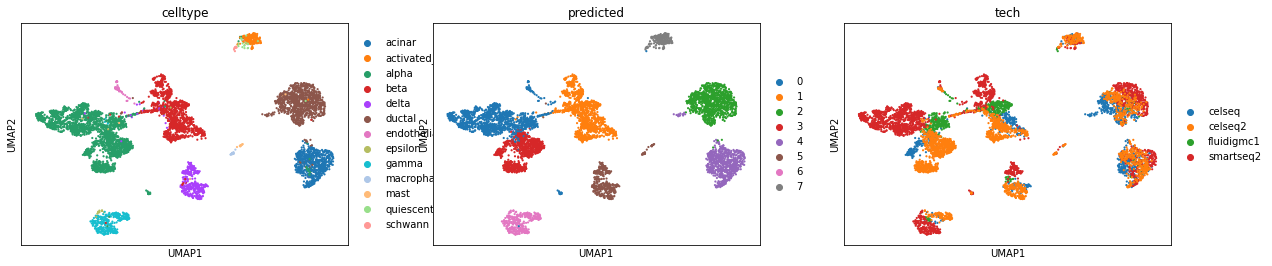

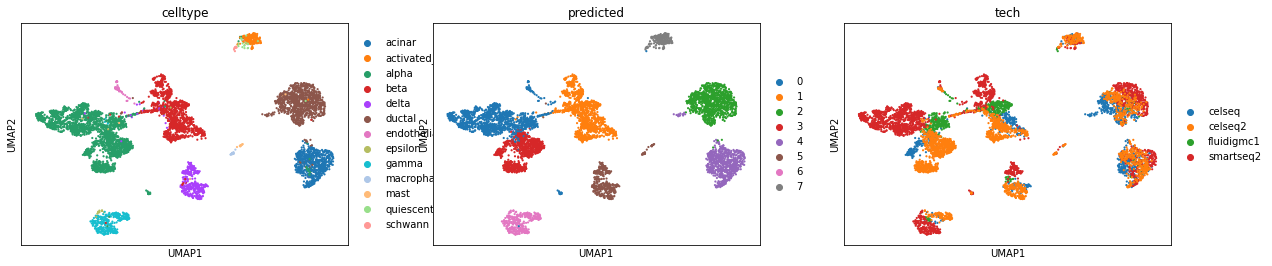

In [34]:
MNN_HVG = MNNdata_frame.copy()
indices = [x in HVGs for x in list(MNN_HVG.var.index)]
MNN_HVG = MNN_HVG[:, indices]

sc.tl.pca(MNN_HVG, svd_solver='arpack')
sc.pp.neighbors(MNN_HVG, n_neighbors = 15)
sc.tl.umap(MNN_HVG)
res = find_resolution(MNN_HVG, 8)
MNN_HVG = sc.tl.louvain(MNN_HVG, resolution = res, copy = True)

labels = MNN_HVG.obs['louvain']
MNN_HVG.obs['predicted'] = MNN_HVG.obs['louvain']
type_strings = list(MNN_HVG.obs['celltype'])

print("MNN Batch Corrected Clustering Results for HVG")

visual = sc.pl.umap(MNN_HVG, color = ["celltype", "predicted", "tech"], return_fig=True)
ARI, NMI, Purity = adjusted_rand_score(labels,type_strings), normalized_mutual_info_score(type_strings,labels), purity_score(type_strings,labels)

print ("ARI = {0:.4f}".format(ARI)) 
print ("NMI = {0:.4f}".format(NMI)) 
print ("Purity = {0:.4f}".format(Purity))

visual

"""Figure info for main paper"""
ARI_data_gene.iloc[4,:3] = ARI, NMI, Purity
DF = pd.DataFrame(MNN_HVG.obsm['X_umap'])
DF.columns = ['UMAP1', 'UMAP2']
DF['Technology'] = MNN_HVG.obs['tech'].values
DF['Cell Type'] = MNN_HVG.obs['celltype'].values
DF.index = MNN_HVG.obs.index

base_path = 'MNN_HVG.csv'
path = os.path.join(figure_path, base_path)

DF.to_csv(path)

visual

Then, we cluster cells using the batch corrected counts of lowly variable genes using scanpy. We visualize the corrected counts using UMAP, and compute the various clustering accuracy metrics.

/Users/jlakkis/anaconda3/envs/cardec_alternatives/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
... storing 'celltype' as categorical
... storing 'tech' as categorical


MNN Batch Corrected Clustering Results for LVG
ARI = 0.3238
NMI = 0.4946
Purity = 0.6235


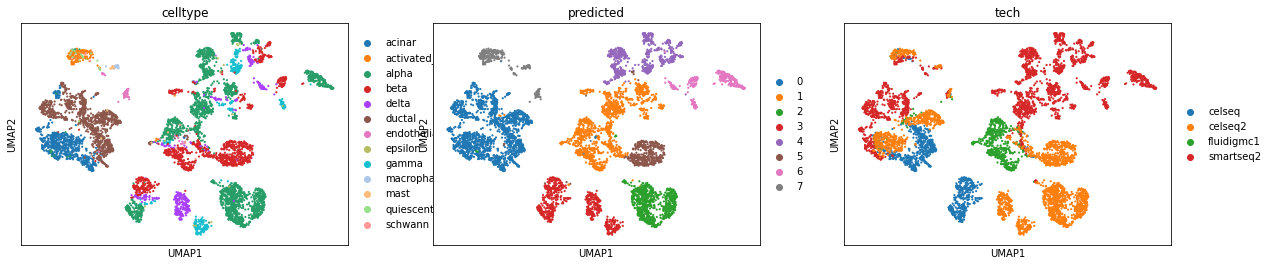

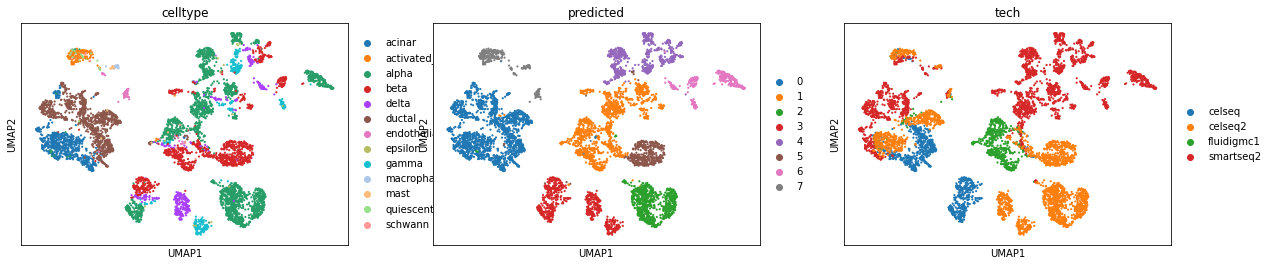

In [35]:
MNN_LVG = MNNdata_frame.copy()
indices = [x not in HVGs for x in list(MNN_LVG.var.index)]
MNN_LVG = MNN_LVG[:, indices]

sc.tl.pca(MNN_LVG, svd_solver='arpack')
sc.pp.neighbors(MNN_LVG, n_neighbors = 15)
sc.tl.umap(MNN_LVG)
res = find_resolution(MNN_LVG, 8)
MNN_LVG = sc.tl.louvain(MNN_LVG, resolution = res, copy = True)

labels = MNN_LVG.obs['louvain']
MNN_LVG.obs['predicted'] = MNN_LVG.obs['louvain']
type_strings = list(MNN_LVG.obs['celltype'])

print("MNN Batch Corrected Clustering Results for LVG")

visual = sc.pl.umap(MNN_LVG, color = ["celltype", "predicted", "tech"], return_fig=True)
ARI, NMI, Purity = adjusted_rand_score(labels,type_strings), normalized_mutual_info_score(type_strings,labels), purity_score(type_strings,labels)

print ("ARI = {0:.4f}".format(ARI)) 
print ("NMI = {0:.4f}".format(NMI)) 
print ("Purity = {0:.4f}".format(Purity))

"""Figure info for main paper"""
ARI_data_gene.iloc[5,:3] = ARI, NMI, Purity
DF = pd.DataFrame(MNN_LVG.obsm['X_umap'])
DF.columns = ['UMAP1', 'UMAP2']
DF['Technology'] = MNN_LVG.obs['tech'].values
DF['Cell Type'] = MNN_LVG.obs['celltype'].values
DF.index = MNN_LVG.obs.index

base_path = 'MNN_LVG.csv'
path = os.path.join(figure_path, base_path)

DF.to_csv(path)

ARI_HVGo_gene.to_csv(os.path.join(figure_path_supplement, 'genespaceARIs_competitors_HVGo.csv'))
ARI_data_gene.to_csv(os.path.join(figure_path, 'genespaceARIs_competitors.csv'))

visual

Now, we cluster cells using the batch corrected counts of all genes using scanpy. We visualize the corrected counts using UMAP, and compute the various clustering accuracy metrics.

/Users/jlakkis/anaconda3/envs/cardec_alternatives/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/jlakkis/anaconda3/envs/cardec_alternatives/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/jlakkis/anaconda3/envs/cardec_alternatives/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/jlakkis/anaconda3/envs/cardec_alternatives/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/jlakkis/anaconda3/envs/cardec_alterna

MNN Batch Corrected Clustering Results for All Genes
ARI = 0.4644
NMI = 0.6129
Purity = 0.7231


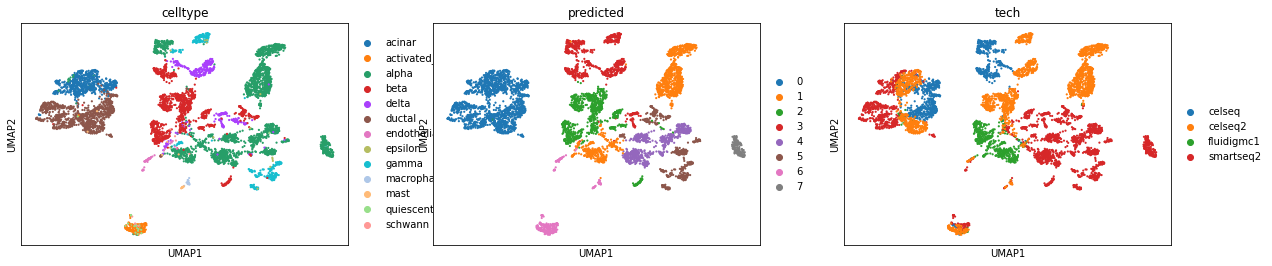

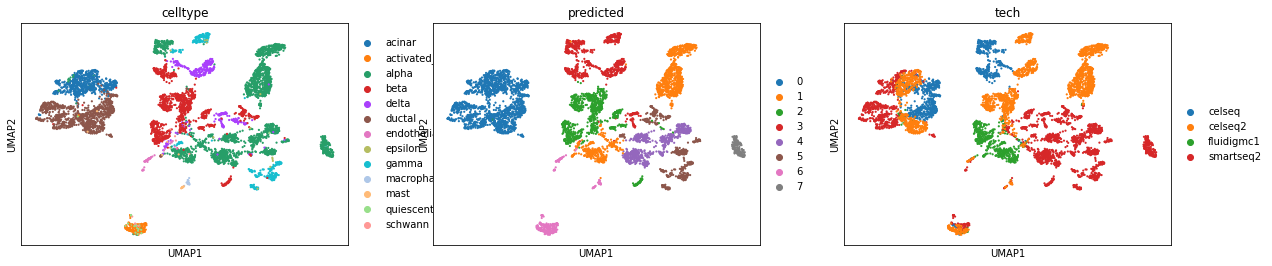

In [36]:
sc.tl.pca(MNNdata_frame, svd_solver='arpack')
sc.pp.neighbors(MNNdata_frame, n_neighbors = 15)
sc.tl.umap(MNNdata_frame)
res = find_resolution(MNNdata_frame, 8)
MNNdata_frame = sc.tl.louvain(MNNdata_frame, resolution = res, copy = True)

labels = MNNdata_frame.obs['louvain']
MNNdata_frame.obs['predicted'] = MNNdata_frame.obs['louvain']
type_strings = list(MNNdata_frame.obs['celltype'])

print("MNN Batch Corrected Clustering Results for All Genes")

visual = sc.pl.umap(MNNdata_frame, color = ["celltype", "predicted", "tech"], return_fig=True)
ARI, NMI, Purity = adjusted_rand_score(labels,type_strings), normalized_mutual_info_score(type_strings,labels), purity_score(type_strings,labels)

print ("ARI = {0:.4f}".format(ARI))
print ("NMI = {0:.4f}".format(NMI))
print ("Purity = {0:.4f}".format(Purity))

visual